# SUPER COMPUTAÇÃO
Fernando Fincatti, 7º semestre

### INTRODUÇÃO

O presente trabalho tem como objetivo a análise de todas as 6 implementações desenvolvidas ao longo do curso de super computação, sendo elas: solução heurística, busca local, busca exaustiva, busca exaustiva paralelizada em CPU e busca exaustiva paralelizada em CPU + GPU.

Todos os algoritmos tem como função resolver o problema de alinhamento de sequências de DNA, o qual consiste no processo de comparar duas ou mais sequências de bases de forma a se observar seu nível de similaridade, que por sua vez pode ser calculado com base em um sistema de pontuação, no qual acertos (MATCH) resultam em pontos positivos, ao passo que os erros (MISS MATCH ou GAPS) resultam em pontos negativos. 

O sistema de pontuação utilizado é apresentado abaixo:

*   MATCH = 2
*   MISS MATCH = -1
*   GAP = -1

Dessa forma, cada uma das 6 abordagens tem como objetivo encontrar o máximo nível de similaridade, o score, entre as duas sequências de entrada.




#### SOLUÇÃO HEURÍSTICA

A abordagem da solução heurística consiste em utilizar o algoritmo de Smith-Walterman para computar o score para duas sequências.

O resultado obtido, o score, é sempre o máximo global para a entrada dado ao algoritmo, uma vez que é necessário preencher uma matriz completa, calculando todos os possíveis valores, retornando apenas o maior.

Para realizar a implementação, cada célula da matriz é uma struct, o qual contém não só o valor do melhor score para aquela célula, mas também um par de coordenadas (x,y), apontando de onde aquele score foi originado, ou seja, se foi feito uma inserção, deleção ou alinhamento para chegar até o valor obtido. Portanto, ao chegar ao final da matriz, é possível saber todo o caminho que originou o melhor score, basta ir voltando pelas coordenadas (x,y) apontandas por cada célula, partindo-se inicialmente do maior score.

#### BUSCA LOCAL

A proposta do algoritmo de busca local é gerar uma aleatorização, de forma que dado duas sequências A e B, são geradas p subsequências (sa) e comparado cada par (sa, sb) salvando o valor do melhor score. 

Não foi necessário utilizar durante o desenvolvimento o algoritmo de Smith-Walterman para computar o score, uma vez que as subsequências geradas possuem sempre o mesmo tamanho, ou seja, é possível fazer uma comparação simples, letra por letra, o que inclusive é mais rápido do que calcular toda a matriz, como na abordagem heurística.

É importante notar que essa abordagem não retorna, necessariamente, o valor máximo global, uma vez que não compara todas as possíveis subsequências. Além disso, o resultado pode variar de acordo com o valor p gerado.

#### BUSCA EXAUSTIVA

O algoritmo de busca exaustiva tem como objetivo encontrar sempre o máximo global para duas sequências de nucleotídeos. 

O funcionamento consiste em, dado duas sequências A e B, gerar todas as subsequências possíveis para ambas e comparar todas as possíveis combinações de subsequência, retornando o melhor valor encontrado.

Para a primeira versão (busca exaustiva [01]) foi usado o Smith-Walterman para computar o score, já na segunda versão (busca exaustiva [02]) foi usado o Smith-Walterman quando as subsequências possuiam tamanhos diferentes, e o cálculo via score simples (comparação letra a letra) quando as subsequências tinham tamanhos iguais.

Vale notar que essa abordagem certamente demanda muito tempo de processamento, uma vez que resolve o problema na força bruta, computando todos os resultados possíveis.

Durante as análises, serão apresentadas duas implementações desse algoritmo, são elas:

* exaustiva 01: utiliza-se o algoritmo de Smith-Waterman para calcular todos os scores necessários;
* exaustiva 02: utiliza-se o algoritmo de Smith-Waterman somente quando as sequências são de tamanhos diferentes, quando iguais é utilizado o cálculo simplificado, ou seja, letra por letra.

#### BUSCA EXAUSTIVA PARALELIZADA EM CPU (OPENMP)

Tomando como base a implementação apresentada no item anterior, a busca exaustiva, podemos claramente indentificar pontos onde o processamento dos dados poderiam ser paralelos, e dessa forma damos origem há um novo algoritmo, paralelizado usando OpenMp, ou seja, utilizando os diferentes cores da CPU.

Nessa abordagem, temos uma estratégia extremamente parecida com a anterior, porém no loop principal do código, ou seja, o que calcula o score para todas as possíveis combinações de subsequência possíveis, foi adicionado uma configuração para que tudo seja feito de forma paralela. Em outras palavras, cada core da CPU recebe, simultaneamente, um par de subsequências e calcula seu score de forma independente.

É importante resaltar que foram necessárias certas mudanças na estrutura do código. Enquanto a abordagem anterior utilizava dois loops para comparar todas as subsequências de A e B, na abordagem utilizando OpenMp foi necessário transformar tudo em um único laço, deivdo à incompatibilidades na biblioteca, a qual não suporta paralelizar dois loops, um dentro do outro.

#### BUSCA EXAUSTIVA PARALELIZADA EM CPU + GPU (OPENMP + THRUST)

### ANÁLISE

Para efeito de comparação, todos os 6 algoritmos serão expostos à comparações em relação ao tempo de execução e ao resultado encontrado (score).

Durante o processo de análise, foi necessário criar regressões para simular o comportamento das implementações para tamanhos de entradas maiores. Isso ocorre pois algumas abordagens são menos eficientes, em termos de tempo, em relação as outras, como por exemplo a busca exaustiva, tornando-se inviável sua execução para sequências muitos grandes de nucleotídeos.

#### TEMPO DE EXECUÇÃO: TODAS AS ABORDAGENS (PARTE 1)

Para uma primeira análise, foi gerado um gráfico com o resultado de execução de todas as soluções implementadas até o momento, de forma que fosse possível ter um panorâma geral do tempo de execução de cada uma. Análises mais especificas serão abordadas em etapas futuras. A imagem abaixo demonstra os resultados obtidos.

In [1]:
#gloabals
from utils import *
n_size_list = get_n_sizes("n-sizes").split(" ")[1:]
exe_list = ["exe{0}".format(str(i)) for i in range(1, 5)]
input_list = ["input{0}".format(str(i)) for i in range(0, 998)]

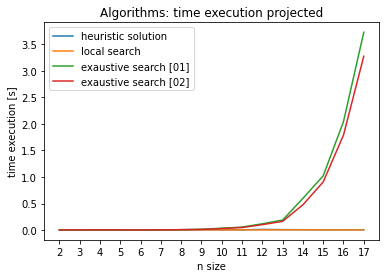

In [2]:
input_cut = 16
results = load_results("./results/hle.pkl")
print_lines(results, n_size_list[0:input_cut], "Algorithms: time execution projected", "n size", "time execution [s]", "clock")

Tendo em vista que não é possível gerar os gráficos para valores muito grandes de N, foram feitas regressões para simular o comportamento dos algoritmos para valores maiores no eixo x. O resultado é apresentado abaixo.

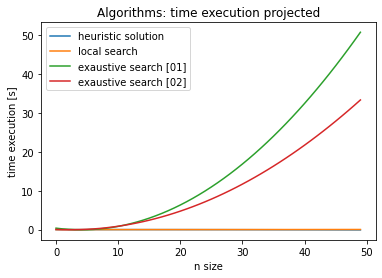

In [3]:
project_cut = 50
projected_results = project_results(results, 0, project_cut)
print_lines(projected_results, range(0, project_cut), "Algorithms: time execution projected", "n size", "time execution [s]", "clock")

#### CONCLUSÃO (PARTE 1)

Com base nos resultados obtidos, podemos tirar algumas conslusões macro dos algortimos apresentados. Em primeiro lugar, é possível notar que os algoritmos de busca local e solução heurística são os que levam menos tempo para retornar um resultado, já que não fazem todas as combinações possíveis como as abordagens de busca exaustiva. As duas abordagens serão analisadas separadamente, devido aos problemas de visualização causados pela escala do gráfico.

Em relação as abordagens de busca exaustiva sem paralelismo, pode-se dizer que existe uma diferença clara entre ambas. O uso do cálculo de score simples para sequências de mesmo tamanho pode não fazer tanta diferença quando temos valores pequenos de N, porém ao projetar os valores utilizando-se de regressões, podemos observar um claro ganho de desempenho entre os dois algoritmos, o que pode se justificar pelo alto custo computancional de preencher as matrizes n x m do Smith-Walterman.

Apesar de que as abordagens que utilizam paralelismo serão abordadas mais para frente de forma separada, pode-se observar que o uso das CPUs/GPU para computar simultaneamente as subsequências geradas resulta em um grande ganho de desempenho, porém o problema continua tendo um comportamento exponencial, de forma que para valores muito grandes de N, ainda demandaria bastante tempo para se encontrar o resultado.

#### TEMPO DE EXECUÇÃO: BUSCA LOCAL E SOLUÇÃO HEURÍSTICA (PARTE 2)

Como observado anteriormente, os algoritmos que executam com menor tempo são o de busca local e heurístico. Portanto vamos analisá-los novamente, porém dessa vez separados para que seja possível monitorar o seu comportamento para valores maiores de N. Os resultados estão apresentados logo abaixo.

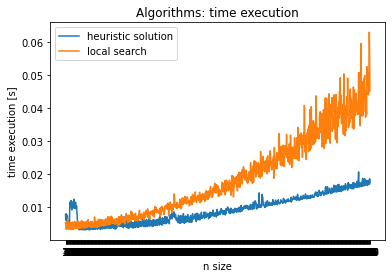

In [13]:
input_cut = 100000
#results_local_and_heuristic = run_multiple_times(['exe1', 'exe2'], input_list[0:input_cut])
#save_results(results_local_and_heuristic, path="./results/hl.pkl")
results_local_and_heuristic = load_results("./results/hl.pkl")
print_lines(results_local_and_heuristic, n_size_list[0:input_cut], "Algorithms: time execution", "n size", "time execution [s]", "clock")

#### CONCLUSÃO (PARTE 2)

Tomando como base o gráfico gerado acima, podemos observar que a solução heurística apresenta resultados muito próximos quando comparado à busca local para valores pequenos de n, entretanto, ao estrapolar o tamanho das sequências observamos uma diferença entre as duas abordagens. Isso pode ser explicado pelo fato de que o número de subsequências, p, geradas pelo algoritmo de busca local é proporcional ao tamanho N da entrada. Em outras palavras, quanto maior a entrada, mais subsequências serão geradas para efeito de comparação, dessa forma ocasionando em um maior tempo de execução.

Pode-se observar que o rúido (oscilação) do algoritmo de busca local aumenta conforme o tamanho da entrada: maior entrada, maior oscilação. Isso ocorre pois o valor de p (número de subsequências) é gerado de forma randômica dentro de um certo range de valores, de forma que P∈S|S = [n, 2n]. Portanto quanto maior o tamanho da entrada, mais valores possíveis P pode assumir, causando o comportamento observado acima.

Vale notar que, apesar da solução heurística retornar o máximo global dos alinhamentos, o algoritmo pode ficar limitado quando os valores de N forem muito grandes. Isso ocorre pois, estrapolando os valores, a matriz necessária para calcular o Smith-Waterman seria enorme, resultando em problemas de alocação de memória.